## 1.0 Import

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from requests.exceptions import ReadTimeout

import time
from difflib import SequenceMatcher
import requests
import regex as re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1.1 Setup

### 1.1.1 Spotipy

In [2]:
keys = extensions = open('../keys/client_keys.txt','r').read().split('\n')
#tokens from spotify dev account to access api
client_id = keys[0].split('=')[1].strip()
client_secret = keys[1].split('=')[1].strip()

In [3]:
#authetification for spotpipy
auth_manager = SpotifyClientCredentials(client_id=client_id, 
                                        client_secret=client_secret)
#spotify search call
sp = spotipy.Spotify(auth_manager=auth_manager, requests_timeout=10, retries=10)

### 1.1.2 Requests

Obtained from [this stackoverflow post](https://stackoverflow.com/questions/74936648/getting-object-of-type-none-is-not-subscriptable-error-while-using-spotify-api)

In [ ]:
auth_url = 'https://accounts.spotify.com/api/token'
base_url = 'https://api.spotify.com/v1/'

#function to generate authentication token in case it expires
def getAuth():
    #post
    auth_response = requests.post(auth_url, {
        'grant_type': 'client_credentials',
        'client_id': client_id,
        'client_secret': client_secret,
    })

    # convert the response to JSON
    auth_response_data = auth_response.json()

    # save the access token
    access_token = auth_response_data['access_token']

    #header for authentification
    headers = {
        'Authorization': 'Bearer {token}'.format(token=access_token)
    }
    
    return headers

headers = getAuth()

### 1.1.3 Loading Disney List

This list of Disney musicals is obtained from [disneymovieslist](https://disneymovieslist.com/list-of-disney-musicals/), and will be used for fetching songs/albums from Spotify and further data from IMDb later on.

In [8]:
disney_df = pd.read_csv('../data/disney_musicals.csv')
disney_df.head()

,movie_id,Title,Year
0,1,Aladdin,1992
1,2,Almost Angels,1962
2,3,Annie,1999
3,4,Babes in Toyland,1961
4,5,Beauty and the Beast,1991


We remove any text within brackets for movie titles as these can cause issues further down the line:

In [9]:
disney_df[disney_df.Title.str.contains(r'\(')]

,movie_id,Title,Year
5,6,Beauty and the Beast (Live-Action),2017
108,109,The Lion King (Live Action),2019
111,112,The Little Mermaid (Live Action),2023


In [10]:
disney_df = pd.read_csv('../data/disney_musicals.csv')
disney_df.head()
bracket_ilocs = disney_df[disney_df.Title.str.contains(r'\(')].index
#regex \( catches '(', '[^)*]' greedly matches any non-')', \) catches')'
disney_df.Title = disney_df.Title.apply(lambda x: re.sub(r'\([^)]*\)','',x).strip())
disney_df.iloc[bracket_ilocs]

,movie_id,Title,Year
5,6,Beauty and the Beast,2017
108,109,The Lion King,2019
111,112,The Little Mermaid,2023


In [11]:
name_year_tuples = list(zip(disney_df.Title,disney_df.Year))
name_year_tuples[:5]

[('Aladdin', 1992),
 ('Almost Angels', 1962),
 ('Annie', 1999),
 ('Babes in Toyland', 1961),
 ('Beauty and the Beast', 1991)]

## 1.2 Querying Spotify API

We can query from Spotipy to find albums matching the movie title as such:

In [12]:
#q is our query, type='album' limits our query to albums only, limit=1 only shows us the first match
sp.search(q='Aladdin',type='album',limit=1)

{'albums': {'href': 'https://api.spotify.com/v1/search?query=Aladdin&type=album&offset=0&limit=1',
  'items': [{'album_type': 'compilation',
    'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0LyfQWJT6nXafLPZqxe9Of'},
      'href': 'https://api.spotify.com/v1/artists/0LyfQWJT6nXafLPZqxe9Of',
      'id': '0LyfQWJT6nXafLPZqxe9Of',
      'name': 'Various Artists',
      'type': 'artist',
      'uri': 'spotify:artist:0LyfQWJT6nXafLPZqxe9Of'}],
    'available_markets': ['AD',
     'AE',
     'AG',
     'AL',
     'AM',
     'AO',
     'AR',
     'AT',
     'AU',
     'AZ',
     'BA',
     'BB',
     'BD',
     'BE',
     'BF',
     'BG',
     'BH',
     'BI',
     'BJ',
     'BN',
     'BO',
     'BR',
     'BS',
     'BT',
     'BW',
     'BZ',
     'CA',
     'CD',
     'CG',
     'CH',
     'CI',
     'CL',
     'CM',
     'CO',
     'CR',
     'CV',
     'CW',
     'CY',
     'CZ',
     'DE',
     'DJ',
     'DK',
     'DM',
     'DO',
     'DZ',
     'EC',
 

The result is a rather long dictionary, but the important parts for us can be sub-selected as such:

In [13]:
test_dict = sp.search(q='Aladdin',type='album',limit=1)['albums']['items'][0]

In [14]:
print(test_dict['name'], test_dict['release_date'])

Aladdin (Original Motion Picture Soundtrack) 2019-05-22


Notice, however, that the example above returned the OST for Aladdin 2019, not Aladdin 1992. We can pick the correct album by implementing an additional step to identify 'Aladdin' by year from the list of all album results (having removed the `limit` arg)

In [15]:
#by default, we get the first 10 albums when we remove limit
all_albums = sp.search(q='Aladdin',type='album')['albums']['items']
#using list comprehension, grab dict with matching release date
test_dict = [temp_dict for temp_dict in all_albums if temp_dict['release_date'][:4]=='1992'][0]

In [16]:
test_dict['name'], test_dict['release_date']

('Aladdin (Original Motion Picture Soundtrack)', '1992-01-01')

### 1.2.2 Iterating and Queerying over DataFrame

Repeating what was done for the 'Aladdin' example, the list of tuples comprised of `(title,year)` can be iterated through:

As some movies will have somewhat differing titles to album names, we try to match on similar names instead

In [17]:
#function to remove brackets
def stringClean(string):
    return re.sub('\([^)]*\)','',string).strip()

#function that returns True if strings are at least two thirds similar
def isSimilar(movie_title,album_title):
    album_title = stringClean(album_title)
    
    movie_split = movie_title.split()
    album_split = album_title.split()
    
    if len(album_split) > len(movie_split):
        album_split = album_split[:len(movie_split)]
        return SequenceMatcher(isjunk=None,a=movie_split,b=album_split).ratio()>=0.75
    else:
        return SequenceMatcher(isjunk=None,a=movie_title,b=album_title).ratio()>=0.75

In [18]:
albums_list = []
#search for Disney artist to obtain ID
for (i,tup) in enumerate(name_year_tuples[:5]):
    name = tup[0]
    year = str(tup[1])
    all_albums = [album for album in sp.search(q=name,type='album')['albums']['items'] 
                  if isSimilar(name,stringClean(album['name']))]
    try:
        album_dict = [temp_dict for temp_dict in all_albums if temp_dict['release_date'][:4]==year][0]
        albums_list.append(album_dict)
    except Exception as e:
        print('Name:',name,'| Year:',year,'| Index:',i)
        print(repr(e))

Name: Almost Angels | Year: 1962 | Index: 1
IndexError('list index out of range')


In [19]:
#create df for better readability
albums_df = pd.DataFrame(data=albums_list)
#some columns are not useful for us
unwanted_cols=['available_markets','external_urls','href','images']
albums_df = albums_df.drop(unwanted_cols,axis=1)

col_reorder = ['name','release_date','release_date_precision',
               'id','artists','album_type','total_tracks','type','uri']

albums_df = albums_df[col_reorder]
albums_df.head()

,name,release_date,release_date_precision,id,artists,album_type,total_tracks,type,uri
0,Aladdin (Original Motion Picture Soundtrack),1992-01-01,day,29EiOQJnxWlX5nVOWQpu3u,[{'external_urls': {'spotify': 'https://open.s...,compilation,21,album,spotify:album:29EiOQJnxWlX5nVOWQpu3u
1,Annie - Original Telefilm Soundtrack,1999-10-04,day,4rEVfFhY5aP2oYee7t8eqn,[{'external_urls': {'spotify': 'https://open.s...,album,17,album,spotify:album:4rEVfFhY5aP2oYee7t8eqn
2,Babes in Toyland,1961-01-01,day,7CgMMSHPx6pXIi3CG8SpLt,[{'external_urls': {'spotify': 'https://open.s...,compilation,16,album,spotify:album:7CgMMSHPx6pXIi3CG8SpLt
3,Beauty and the Beast,1991-01-01,day,3O5p9VNddbwvqWTdYKEqV5,[{'external_urls': {'spotify': 'https://open.s...,compilation,16,album,spotify:album:3O5p9VNddbwvqWTdYKEqV5


### 1.2.3 Matching Based on Disney Copyright

We inspect what happened with _'Almost Angels'_:

In [20]:
name=name_year_tuples[1][0]
year=str(name_year_tuples[1][1])
#search again
angel_albums = [album for album in sp.search(q=name,type='album')['albums']['items'] 
                if isSimilar(name,stringClean(album['name']))]
#print in order of release year
print(sorted([(album['name'],album['release_date'][:4]) for album in angel_albums],
             key=lambda x:x[1]))

[('Almost Angelic', '2014'), ('Almost Angels', '2014'), ('Almost Angels', '2020')]


Since none of the albums match both name and year, it is possible that one of the albums is relevant but has the incorrect release date. A more in-depth check would be to use our `requests` call that we prepared in [Section 1.1.2](#subsect112) to check if the album has a Disney copyright:

Aladdin example

In [21]:
try:
    name = 'Aladdin'
    r = requests.get(base_url+'search/?q={q}&type=album'.format(q=name.replace(' ','%20')), 
                     headers=headers)
    r = r.json()
    r = r['albums']['items'][0]['copyrights']
except Exception as e:
    print(repr(e))

KeyError('copyrights')


In [22]:
name = 'Aladdin'
r = requests.get(base_url+'search/?q={q}&type=album'.format(q=name.replace(' ','%20')), 
                 headers=headers)
r = r.json()
r_id = r['albums']['items'][0]['id']

r = requests.get(base_url+'albums/{idx}'.format(idx=r_id), headers=headers)
r = r.json()

copyrights = r['copyrights']
print(copyrights)

[{'text': '© 2019 Disney Enterprises, Inc.', 'type': 'C'}, {'text': '℗ 2019 Walt Disney Records', 'type': 'P'}]


The search call does not give us enough information; we need to perform 2 steps:

In [23]:
disney_copyrights = ['Disney' in copyright['text'] for copyright in r['copyrights']]
disney_copyrights

[True, True]

In [24]:
#returns value>0 if at least one of the list entries is True
sum(disney_copyrights)

2

Thus, we have

In [25]:
#fetch the spotify album id
angel_ids = [album['id'] for album in angel_albums]
    
for album_id in angel_ids:
    #fetch the correspondiing album for api endpoint
    r = requests.get(base_url+'albums/{album_id}'.format(album_id=album_id), headers=headers)
    #conver to json
    r = r.json()
    #check if at least one of the copyrights belongs to Disney
    cr_check = sum(['Disney' in dic['text'] for dic in r['copyrights']])
    
    #show all albums that belong to Disney
    if cr_check>0:
        print('Album:',r['name'],'\n', 'Released:',r['release_date'],'\n', 'Copyrights:',r['copyrights'])
    else:
        print('Album:',r['name'],'not Disney album')

Album: Almost Angelic not Disney album
Album: Almost Angels not Disney album
Album: Almost Angels not Disney album


The no _Disney_ copyrighted albums. As a result, it seems that for this particular movie, there are no Spotify albums, so we would unfortunately have to skip over it.

_Note: This does not necessarily mean that none of the movie soundtracks exist on Spotify, just that they are not packaged in an album with a similar name to the movie_

```
### Slight Tangent ###
```

```
While doing this project, I realised that some movies were causing issues when trying to retrieve results using spotipy.search(), in particular, this happens with The Cheetah Girls, which I show in this tanget/sidebar
```

In [26]:
name = 'The Cheetah Girls'
names = []
ids = []

search_result = sp.search(q=name, type='album',limit=50)['albums']['items']

cheetah_dict = {'name': [album['name'] for album in search_result],
                  'id': [album['id'] for album in search_result]}

cheetah_df = pd.DataFrame(data=cheetah_dict)

In [27]:
cheetah_df.head()

,name,id
0,The Cheetah Girls 2,10ATF34xwqoGlmm5vsgOSG
1,TCG,0Lur2jUoYNUYEwCdzW6ACb
2,The Cheetah Girls: One World,6H9FjLFzCgX485reYmS3c3
3,The Cheetah Girls - The Party's Just Begun Con...,7D0i8dheUxXue09zKIoylb
4,The Cheetah Girls: A Cheetah-licious Christmas,2dCaJ5ten3q3AbJ2VJZ8MY


This is the correct album tha we are looking for:

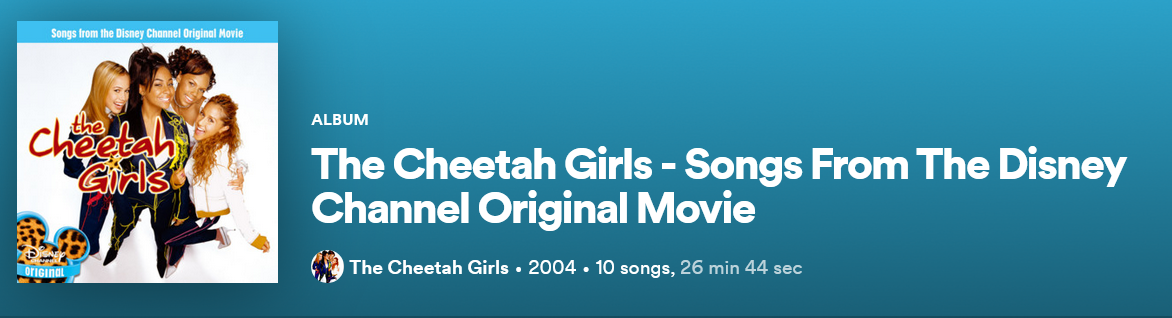

And it corresponds to the following id: `0QZr27D5umJtO3q4a16MvN`

In [28]:
sp.album('0QZr27D5umJtO3q4a16MvN')['name']

'The Cheetah Girls - Songs From The Disney Channel Original Movie'

Checking the `cheetah_df`, however:

In [29]:
cheetah_df[cheetah_df.id=='0QZr27D5umJtO3q4a16MvN']

,name,id


For some reason, spotipy just fails to retrieve this album with its `sp.search` function. However, if we attempt the same using requests to call the Spotify API:

In [30]:
name = 'The Cheetah Girls'
# https://api.spotify.com/v1/search?q=The%20Cheetah%20Girls&type=album&limit=50
r = requests.get(base_url+'search/?q={q}&type=album&limit=50'.format(q=name.replace(' ','%20')), 
                 headers=headers)
r = r.json()

In [31]:
r['albums']['items'][0]['id']

'10ATF34xwqoGlmm5vsgOSG'

``` 
### Sidetrack End ###
```

Now, we go back to implementing our more rigorous procedure and see if it breaks anything that we have already done:

## 1.3 Defining Final Functions

In [32]:
headers=getAuth()

### 1.3.1 Pre-requisite Functions

Here, the pre-requisite functions are defined and described in detail. The reasoning for the use of each function is highlighted immediately after

In [37]:
def stringClean(string):
    '''
    Description:
    Takes a string and removes all text within brackets, removes special characters
    Also converts 'II' Roman to '2' English numeral

    Parameters:
     - string - str type object

    Returns:
    String type object 
    
    Example:
    >>> input:  stringClean('Beauty and the Beast (Original Motion Picture Soundtrack)')
    >>> output: Beauty and the Beast
    '''
    #remove text in brackets
    de_bracket = re.sub('\([^)]*\)','',string).strip()
    #remove apostrophe
    de_apostrophe = re.sub('\'','',de_bracket).strip()
    #replace !?&\/- etc. with space
    de_special = re.sub('[^\w\s]',' ',de_apostrophe).strip()
    clean_string = re.sub('II','2',de_special).strip()
    
    return clean_string 


#function that returns True if strings are at least two thirds similar
def isSimilar(movie_title,album_title):
    
    '''
    Description:
    Compares whether the movie title and album title are similar enough to be considered a match

    Parameters:
     - movie_title - str type object
     - album_title - str type object

    Returns:
    Boolean True or False
    
    Example:
    >>> input:  isSimilar('Beauty and the Beast','Beauty and the Beast (Original Motion Picture Soundtrack)')
    >>> output: True

    '''
    movie_title = stringClean(movie_title)
    album_title = stringClean(album_title) #remove text within brackets
    
    movie_split = movie_title.split()
    album_split = album_title.split() #split into list
    
    #attempt to make the titles similar
    #e.g. movie_split == ['The','Lion','King'], 
    #     album_split == ['The','Lion','King','Soundtracks']
    #then we reduce album_split down to
    #     album_split = album_split[:3]
    #     album_split == ['The','Lion','King']
    if len(album_split) > len(movie_split):
        album_split = album_split[:len(movie_split)]
    elif len(movie_split) > len(album_split):
        movie_split = movie_split[:len(album_split)]
    
    return SequenceMatcher(isjunk=None,a=movie_title,b=album_title).ratio() >= (2/3)

def getAllAlbums(name):
    '''
    Description:
    Takes a movie `name` and finds all albums on spotify that match on name

    Parameters:
     - name - str type object

    Returns:
     - List object of matching albums if matches are found
     - Empty list object if no matches found
    '''
    name = stringClean(name)
    #fetch album name search from spotify api endpoint
    r = requests.get(base_url+'search/?q={q}&type=album'.format(q=name.replace(' ','%20')), headers=headers)
    r = r.json()    #convert to json
    try: #match list of albums with name similarity
        all_albums = [album for album in r['albums']['items'] if isSimilar(name,stringClean(album['name']))]
    except IndexError: #index error occurs when no matches found
        all_albums = []    #return empty list
    return all_albums

def yearDelay(string_date,year,delay=0):
    '''
    Description:
    Inspects release date of album and compares it to release year of movie, returning True if the
    difference between the dates is no longer than `delay`
    
    Parameters:
     - string_date - str type object
     - year - int type object
     - delay - int type object with default value = 0
    
    Returns:
    Boolean True or False
    
    Example:
    >>> input:  yearDelay(string_date='1990',year=1990,delay=1)
    >>> output: True
    '''
    #turns string date into integer year
    int_year = int(string_date[:4])
    #match if album released at most `delay` years after movie
    bool_statement = int_year - year == delay
    
    return bool_statement

def matchYear(all_albums, year):
    '''
    Description:
    Takes list of album dictionaries and subselects based on if album release year is the same as
    movie release year, or if there is at most a 1-year delay between the two
    
    Parameters:
     - all_albums - list type object made up of dict type objects
     - year - int type object
    
    Returns:
     - List type object made up of dict type objects if matches are found
     - Empty list type object if no matches are found
    '''
                       
    album_dicts = [album for album in all_albums if yearDelay(album['release_date'],year)]
    
    if len(album_dicts)==0:
        album_dicts = [album for album in all_albums if yearDelay(album['release_date'],year,delay=1)]
    
    return album_dicts

def narrowAlbums(album_dicts):
    '''
    Description:
    Takes a list of album dictionaries which have been matched on name and release year and checks if
    any of them are different versions of the same album (e.g. Deluxe Version, Original soundtrack, 
    Broadway soundtrack) etc.

    Album is selected in order of following preference
        Deluxe Edition > Original Motion Picture Soundtrack > Not a Broadway album
    
    Parameters:
     - album_dicts - list of dict type objects
    
    Returns:
     - Dict object if the conditions match
     - List object identical to input if no conditions match
     
    Example:
    >>> input:  narrowAlbums([{..., 'name': 'Annie', ...}, {..., 'name': 'Annie Broadway Musical',...}]
    >>> output: {..., 'name':'Annie',...}
    '''
    check_deluxe = ['Deluxe Edition' in album['name'] for album in album_dicts]
    check_original = ['Original Motion' in album['name'] for album in album_dicts]
    check_broadway = ['Broadway' in album['name'] for album in album_dicts]
    
    if sum(check_deluxe)>0:
        album_dict = album_dicts[check_deluxe.index(True)]
    elif sum(check_original)>0:
        album_dict = album_dicts[check_original.index(True)]
    elif sum(check_broadway)>0:
        album_dict = album_dicts[check_broadway.index(False)]
    else:
        album_dict = album_dicts
        
    return album_dict
    
def matchCopyright(all_albums):
    '''
    Description:
    Takes list of album dictionaries and queries spotify api for their specific album id to identify
    copyright holders for those albums, returning list of all albums with a Disney copyright.
    
    Parameters:
     - all_albums - list of dictionaries
     
    Returns:
     - List of dictionaries
    '''
    temp_list = [] #to check if we end up with multiple matching albums
    #create list of all album ids
    album_ids = [album['id'] for album in all_albums]

    for (idx,album_id) in enumerate(album_ids):
        try:
            #fetch the correspondiing album for api endpoint
            r = requests.get(base_url+'albums/{album_id}'.format(album_id=album_id), headers=headers)
            #conver to json
            r = r.json()
        except ReadTimeout:    #spotify sometimes times out and we have to retry
            print('Spotify timed out... trying again...')
            #repeat as above
            r = requests.get(base_url+'albums/{album_id}'.format(album_id=album_id), headers=headers)
            r = r.json()

        #check if at least one of the copyrights belongs to Disney
        cr_check = sum(['Disney' in dic['text'] for dic in r['copyrights']])

        #confirm album has disney copyright
        if cr_check>0:
            temp_list.append(all_albums[idx])
            
    return temp_list


    
| Function(s)               | Reasoning                                                                       |
| ------------------------  | ------------------------------------------------------------------------------- |
| `stringClean`             | remove brackets, apostrophes, and some characters for better matching           |
| `isSimilar`               | identify if album and movie names are similar, allowing for some discrepancie   |
| `getAllAlbums`            | get list of all albums that match on name                                       |
| `yearDelay` & `matchYear` | identify which albums from list have same release date or are released at most `delay` years later. (Note, we don't take absolute year difference because it doesn't make sense for a movie soundtrack to be released after the movie, but it does make sense for a delay in the OST release) |
| `narrowAlbums`            | many albums are available in multiple versions, e.g. deluxe and normal edition. Some musicals also exist as Broadway theatricals and those might have separate albums. Where possible, a preference for Deluxe Edition > Original Soundtrack >Broadway is taken. Ideally, we would not accept Broadway albums but if no other albums exist, the broadway version at least offers a proxy for information. |
| `matchCopyright`          | some albums may match on name and year through coincidence. If this happens, we want to make sure that we only select albums that have Disney copyrights to determine the true match between album and movie                                |

In [370]:
albums_list = []
copyright_single_list = []
copyright_multiple_list = []
failed_list = []
multiple_list = []

headers = getAuth()
#search for Disney artist to obtain ID
for (i,tup) in enumerate(name_year_tuples):
    #assign anme an year
    name = tup[0]
    year = tup[1]
    #dictionary to keep track of errors
    movie_dict = {'movie_name':name, 'movie_year':year, 'movie_id':i+1}
    #all albums with a similar name to movie title
    all_albums = getAllAlbums(name)
        
    if len(all_albums)==0:    #if we have no matches
        failed_list.append(movie_dict)
        album_dict = 0
    #-----------------------------------------------------------------------------------------#
    else:    
        #list of albums roughly matching release year from those matching names
        album_dicts = matchYear(all_albums,year)

        if len(album_dicts)==1:
            #if single match, list len is 1, so return the only match
            album_dict = album_dicts[0]
        #-------------------------------------------------------------------------------------#
        elif len(album_dicts)>1:
            #if multiple matches, narrow down albums based on deluxe/original/not-broadway
            #if none of the albums meet conditions, the same input list is returned
            album_dict = narrowAlbums(album_dicts)    
            
            #if we fail to narrow down albums
            if type(album_dict)==list and len(album_dict)>1: 
                multiple_list.append(movie_dict)    #keep track if multiple albums match
                album_dict = album_dict[0]    #just return first copy
        #-------------------------------------------------------------------------------------#
        #albums match on name but not year 
        elif len(album_dicts)==0: 
            #get list of albums that have disney copyright from those that match on name
            temp_list = matchCopyright(all_albums)

            if len(temp_list)>1:    #multiple matches
                copyright_multiple_list.append(movie_dict)    #keep track of what movies we got from cr
                album_dict = temp_list[0]    #just return first copy
            elif len(temp_list)==1:
                copyright_single_list.append(movie_dict)    #keep track
                album_dict = temp_list[0]
                #append with relational schema to movie
            else:
                failed_list.append(movie_dict)
                album_dict = 0
        #-------------------------------------------------------------------------------------#
    #-----------------------------------------------------------------------------------------#
    if album_dict != 0:    #if we got a match somewhere along the way
        album_dict['movie_id'] = i+1    #add movie id to dict
        albums_list.append(album_dict)    #add dict to results

In [371]:
len(albums_list),len(copyright_single_list),len(copyright_multiple_list), len(multiple_list),len(failed_list)

(103, 8, 17, 15, 22)

In [372]:
albums_df = pd.DataFrame(data=albums_list)
copyright_single_df = pd.DataFrame(data=copyright_single_list)
copyright_multiple_df = pd.DataFrame(data=copyright_multiple_list)
multiple_df = pd.DataFrame(data=multiple_list)
failed_df = pd.DataFrame(data=failed_list)

View the 8 movies that we had to match using the `matchCopyright` method:

In [38]:
name = 'The Little Mermaid 2'
r = requests.get(base_url+'search/?q={q}&type=album'.format(q=name.replace(' ','%20')), headers=headers)
r = r.json()

ConnectionError: HTTPSConnectionPool(host='api.spotify.com', port=443): Max retries exceeded with url: /v1/search/?q=The%20Little%20Mermaid%202&type=album (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000163A93E5670>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))

In [39]:
headers = getAuth()

In [40]:
a = 'The Little Mermaid II: Return to the Sea'

In [43]:
[a['name'] for a in getAllAlbums(a)]

ConnectionError: HTTPSConnectionPool(host='api.spotify.com', port=443): Max retries exceeded with url: /v1/search/?q=The%20Little%20Mermaid%202%20%20Return%20to%20the%20Sea&type=album (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x00000163A9654FD0>: Failed to establish a new connection: [WinError 10051] A socket operation was attempted to an unreachable network'))

In [42]:
view_cols = ['id','name','release_date','movie_name','movie_year']
merge_copysingle_df = albums_df.merge(copyright_single_df,on='movie_id',how='right')[view_cols].sort_values(by='name')
merge_copysingle_df

NameError: name 'copyright_single_df' is not defined

In [ ]:
test_list = albums_df[albums_df['name'].str.contains('Enchanted Christmas')].to_dict('records')

Manual checks cross-referencing Spotify and Wikipedia show that the correct `id` values should be:

In [302]:
copyright_single_ids = ['5HnvqWzFrgJ2LFa1pccKMz', '0qTBASJ7RydzzYA1GWq5sL', '3zndTHj0OiNxABnyXsU5DF',
                        '6R3voGYHT27CMIoWI9b1i1', '6N66L2LIBhnhir4G5rMmZJ', '7K2x3w8QLIGYljgafIP0pC']
copyright_single_ids 

['5HnvqWzFrgJ2LFa1pccKMz', '0qTBASJ7RydzzYA1GWq5sL', '3zndTHj0OiNxABnyXsU5DF']

However, something interesting happens with _'Oliver and Company'_

In [301]:
#get top 50 matches
r = requests.get(base_url+'search/?q=Oliver%20and%20Company&type=album&limit=50',headers=headers)
r = r.json()
#check if we find the album with the correct matching id
[album['id'] for album in r['albums']['items'] if album['id']=='3zndTHj0OiNxABnyXsU5DF']

[]

None of the albums match the correct ID even though the correct album exists on Spotify!

This seems to be a known issue where neither the `spotipy` library nor the `requests` library can retrieve the correct album. 

Interestingly, using the [Spotify for Developers](https://developer.spotify.com/console/get-search-item/) page and querying `q=Oliver and Company`, `type=album` then using `Ctrl+F` to search for `3zndTHj0OiNxABnyXsU5DF`, the result is found!

Unfortunately, this means that automatic fetching of data is not ideal and does not work as cleanly as intended when using Spotify API calls. Instead, a somewhat happy middle-ground is to just use the checks we are using to try and automatically fetch some albums, and manually check for errors along the way to ensure data integrity.

In [168]:
view_cols = ['id','name','release_date','movie_name','movie_year']
albums_df.merge(copyright_multiple_df,on='movie_id',how='right')[view_cols].sort_values(by='name')

,id,name,release_date,movie_name,movie_year
8,6hcQqEfqHDkQZl1bdgr4Vr,101 Dalmatians,1998-01-01,101 Dalmatians,1961
9,1Sfipn1VH7Q0ZSPfXz7oOx,Alice In Wonderland (Original Motion Picture S...,1997-01-01,Alice in Wonderland,1951
10,3QAxBLpXRLVMh1dRtuQa0q,Cinderella Special Edition (Original Motion Pi...,2005-10-19,Cinderella,1950
0,1vZDNugpxSBKlBkU2W1mR1,Dumbo,1997-01-01,Dumbo,1941
11,6yiERKWqeJIEC9OQzhyRcu,Fantasia,1990-01-01,Fantasia,1940
1,5nmEqzKRjL3WyA5X7Zppdc,Lady and The Tramp and Friends,2006-01-01,Lady and the Tramp,1955
2,4I53uIfFAiQPKjXFNN2k4d,Mary Poppins,1997-01-01,Mary Poppins,1964
3,293ydefC5qpqZ65JYZTbUi,"Once Upon a Dream (from ""Maleficent"") [Origina...",2014-01-01,Once Upon a Mattress,2005
4,1YrocR69AHthl982tykNpQ,Pete's Dragon (Original Motion Picture Soundtr...,2016-08-12,Pete's Dragon,1977
12,1tCVqfTbVWmXFXx0HmGkob,Peter Pan (Original Motion Picture Soundtrack),1997-01-01,Peter Pan,1953


Remember, `multiple_albums` is a list of movies that matched on name but the year difference was one or more years.

#### multi test

In [834]:
i=3

In [835]:
name = multiple_albums[i]['movie_name']
year = multiple_albums[i]['movie_year']

In [836]:
all_albums = getAllAlbums(name)

In [837]:
album_dicts = matchNameYear(all_albums,year)

In [838]:
for album in album_dicts:
    print(album['name'],album['release_date'])

Frozen 2 (Original Motion Picture Soundtrack/Deluxe Edition) 2019-11-15
Frozen 2 (Banda Sonora Original en Español/Edición Deluxe) 2019-11-15
Frozen 2 (Mandarin Original Motion Picture Soundtrack) 2019-11-16
Frozen 2 (Original Motion Picture Soundtrack/Japanese Version) 2019-11-22
Frozen 2 (Korean Original Motion Picture Soundtrack) 2019-11-15
Frozen 2 (Banda Sonora Original en Castellano/Deluxe Edition) 2019-11-15
Frozen 2 (Russian Original Motion Picture Soundtrack/Deluxe Edition) 2019-11-15


In [839]:
check_deluxe = ['Deluxe' in album['name'] for album in album_dicts]
check_original = ['Original' in album['name'] for album in album_dicts]
check_broadway = ['Broadway' in album['name'] for album in album_dicts]

if sum(check_deluxe)>0:
    album_dict = album_dicts[check_deluxe.index(True)]
elif sum(check_original)>0:
    album_dict = album_dicts[check_original.index(True)]
elif sum(check_broadway)>0:
    album_dict = album_dicts[check_broadway.index(False)]
else:
    album_dict = album_dicts

type(album_dict)

dict

In [817]:
for album in album_dicts:
    print(album['name'],album['release_date'])

Beauty and the Beast (Original Motion Picture Soundtrack/Deluxe Edition) 2017-03-10
Beauty and the Beast 2017-03-17


In [843]:
multiple_albums

[{'movie_name': 'High School Musical 2', 'movie_year': 2007, 'index': 18},
 {'movie_name': 'High School Musical 3: Senior Year',
  'movie_year': 2008,
  'index': 19},
 {'movie_name': 'Mulan', 'movie_year': 1998, 'index': 30},
 {'movie_name': 'Pocahontas', 'movie_year': 1995, 'index': 35},
 {'movie_name': 'Teen Beach Movie', 'movie_year': 2013, 'index': 43},
 {'movie_name': 'Better Nate Than Ever', 'movie_year': 2022, 'index': 59},
 {'movie_name': 'Black is King', 'movie_year': 2020, 'index': 60},
 {'movie_name': 'Clouds', 'movie_year': 2020, 'index': 67},
 {'movie_name': 'Descendants 2', 'movie_year': 2017, 'index': 70},
 {'movie_name': 'Descendants 3', 'movie_year': 2019, 'index': 71},
 {'movie_name': 'Freaky Friday', 'movie_year': 2018, 'index': 75},
 {'movie_name': 'Hannah Montana: The Movie', 'movie_year': 2009, 'index': 77},
 {'movie_name': 'Hollywood Stargirl', 'movie_year': 2022, 'index': 78},
 {'movie_name': 'Sneakerella', 'movie_year': 2022, 'index': 93},
 {'movie_name': 'Spin

In [ ]:
b = multiple_albums[5]
name = b['movie_name']
year = b['movie_year']

all_albums = getAllAlbums(name,'album')

for (i,album) in enumerate(sorted(all_albums, key=lambda x: int(x['release_date'][:4]))):
    print(i,album['name'],album['release_date'], SequenceMatcher(isjunk=None,a=name,b=stringClean(album['name'])).ratio())
# if len(all_albums)==0:
#     failed_list.append(movie_dict)
# else:    #if we have at least one match
#     try:
#         #get first instance of matching album with same year release
#         album_dict = [temp_dict for temp_dict in all_albums if temp_dict['release_date'][:4]==year][0]
#         #update full dictionary
#         full_dict.update(album_dict)
#         #add to list of albums
#         albums_list.append(full_dict)

#### creating df

In [931]:
#reload df as before to avoid errors when re-running cells
albums_df = pd.DataFrame(data=albums_list)
unwanted_cols=['available_markets','external_urls','href','images']
albums_df = albums_df.drop(unwanted_cols,axis=1)

col_reorder = ['movie_id','movie_name','movie_year','name','release_date','release_date_precision',
               'id','artists','album_type','total_tracks','type','uri']

albums_df = albums_df[col_reorder]
albums_df.head()

,movie_id,movie_name,movie_year,name,release_date,release_date_precision,id,artists,album_type,total_tracks,type,uri
0,0,Aladdin,1992,Aladdin (Original Motion Picture Soundtrack),1992-01-01,day,29EiOQJnxWlX5nVOWQpu3u,[{'external_urls': {'spotify': 'https://open.s...,compilation,21,album,spotify:album:29EiOQJnxWlX5nVOWQpu3u
1,2,Annie,1999,Annie - Original Telefilm Soundtrack,1999-10-04,day,4rEVfFhY5aP2oYee7t8eqn,[{'external_urls': {'spotify': 'https://open.s...,album,17,album,spotify:album:4rEVfFhY5aP2oYee7t8eqn
2,3,Babes in Toyland,1961,Babes in Toyland,1961-01-01,day,7CgMMSHPx6pXIi3CG8SpLt,[{'external_urls': {'spotify': 'https://open.s...,compilation,16,album,spotify:album:7CgMMSHPx6pXIi3CG8SpLt
3,4,Beauty and the Beast,1991,Beauty and the Beast,1991-01-01,day,3O5p9VNddbwvqWTdYKEqV5,[{'external_urls': {'spotify': 'https://open.s...,compilation,16,album,spotify:album:3O5p9VNddbwvqWTdYKEqV5
4,5,Beauty and the Beast,2017,Beauty and the Beast (Original Motion Picture ...,2017-03-10,day,3AhP76AusdcJ9sZ4XgUcEc,[{'external_urls': {'spotify': 'https://open.s...,compilation,52,album,spotify:album:3AhP76AusdcJ9sZ4XgUcEc


In [932]:
albums_df = pd.DataFrame(data=albums_list)
unwanted_cols=['available_markets','external_urls','href','images']
albums_df = albums_df.drop(unwanted_cols,axis=1)

The artists field is somewhat unreadable in its current state and, therefore, needs to be fixed:

In [933]:
albums_df.artists[:4]

0    [{'external_urls': {'spotify': 'https://open.s...
1    [{'external_urls': {'spotify': 'https://open.s...
2    [{'external_urls': {'spotify': 'https://open.s...
3    [{'external_urls': {'spotify': 'https://open.s...
Name: artists, dtype: object

In [934]:
albums_df.artists[0]

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/0LyfQWJT6nXafLPZqxe9Of'},
  'href': 'https://api.spotify.com/v1/artists/0LyfQWJT6nXafLPZqxe9Of',
  'id': '0LyfQWJT6nXafLPZqxe9Of',
  'name': 'Various Artists',
  'type': 'artist',
  'uri': 'spotify:artist:0LyfQWJT6nXafLPZqxe9Of'}]

The artist entry is a list with a single dictionary entry, for our purposes, the `name` alone is enough.

In [935]:
#reload df as before to avoid errors when re-running cells
albums_df = pd.DataFrame(data=albums_list)
unwanted_cols=['available_markets','external_urls','href','images']
albums_df = albums_df.drop(unwanted_cols,axis=1)
#apply lambda to retrieve just the name
albums_df['artists'] = albums_df['artists'].apply(lambda x: x[0]['name'])

col_reorder = ['movie_id','movie_name','movie_year','name','release_date','release_date_precision',
               'id','artists','album_type','total_tracks','type','uri']

albums_df = albums_df[col_reorder]

In [936]:
albums_df

,movie_id,movie_name,movie_year,name,release_date,release_date_precision,id,artists,album_type,total_tracks,type,uri
0,0,Aladdin,1992,Aladdin (Original Motion Picture Soundtrack),1992-01-01,day,29EiOQJnxWlX5nVOWQpu3u,Various Artists,compilation,21,album,spotify:album:29EiOQJnxWlX5nVOWQpu3u
1,2,Annie,1999,Annie - Original Telefilm Soundtrack,1999-10-04,day,4rEVfFhY5aP2oYee7t8eqn,Charles Strouse,album,17,album,spotify:album:4rEVfFhY5aP2oYee7t8eqn
2,3,Babes in Toyland,1961,Babes in Toyland,1961-01-01,day,7CgMMSHPx6pXIi3CG8SpLt,Various Artists,compilation,16,album,spotify:album:7CgMMSHPx6pXIi3CG8SpLt
3,4,Beauty and the Beast,1991,Beauty and the Beast,1991-01-01,day,3O5p9VNddbwvqWTdYKEqV5,Various Artists,compilation,16,album,spotify:album:3O5p9VNddbwvqWTdYKEqV5
4,5,Beauty and the Beast,2017,Beauty and the Beast (Original Motion Picture ...,2017-03-10,day,3AhP76AusdcJ9sZ4XgUcEc,Various Artists,compilation,52,album,spotify:album:3AhP76AusdcJ9sZ4XgUcEc
...,...,...,...,...,...,...,...,...,...,...,...,...
98,120,Up,2009,Up (Original Motion Picture Soundtrack),2009-01-01,day,5yN2LiMaA7nEXT35GW4hNu,Michael Giacchino,compilation,26,album,spotify:album:5yN2LiMaA7nEXT35GW4hNu
99,121,Wreck-It Ralph,2012,Wreck-It Ralph,2012-01-01,day,0aqJGQ73RTLu3yLgcdU9JC,Various Artists,compilation,25,album,spotify:album:0aqJGQ73RTLu3yLgcdU9JC
100,122,Zombies 2,2020,Zombies 2 On Piano,2020-02-27,day,7hcCwIEj9L2btkFOoKHnOA,Piano Vampire,album,10,album,spotify:album:7hcCwIEj9L2btkFOoKHnOA
101,123,Zombies 3,2022,Zombies 3 on Piano,2022-08-15,day,38vKXedQhbA0Wtaz4Y6DE4,Oyster Lovers,album,8,album,spotify:album:38vKXedQhbA0Wtaz4Y6DE4


In [937]:
albums_df.to_csv('../data/movie_albums.csv')